# 03. Component Analysis

**Purpose:** Understand which RAG components matter most and how they interact.

**Key Questions:**
- Which components explain the most variance in performance?
- What are the best values for each component?
- Are there synergistic or redundant combinations?

In [1]:
from analysis_utils import (
    load_all_results, setup_plotting,
    compute_marginal_means, identify_bottlenecks,
    analyze_interactions, find_synergistic_combinations,
    plot_component_effects, plot_interaction_heatmap,
    PRIMARY_METRIC
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

setup_plotting()

# Load data
df = load_all_results()
rag_df = df[df['exp_type'] == 'rag']

print(f"Loaded {len(rag_df)} RAG experiments")

Loaded 118 RAG experiments


## 3.1 Bottleneck Identification

Which components contribute most to performance variance?

Bottleneck Identification
Variance explained by each component:

  model_short          | █████████████████          35.5%
  prompt               | ████████                   17.3%
  retriever_type       | ████                        9.9%
  top_k                | █                           2.3%
  embedding_model      | █                           2.1%
  query_transform      |                             1.2%
  reranker             |                             0.2%

→ Top bottleneck: model_short (35.5% of variance)
  This is where optimization will have the biggest impact.


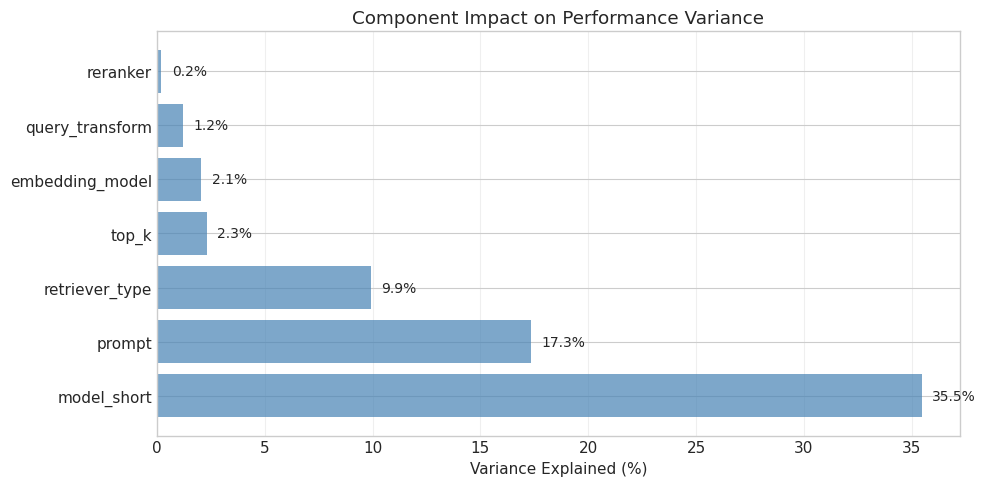

In [2]:
if len(rag_df) > 0:
    bottlenecks = identify_bottlenecks(df)
    
    if bottlenecks:
        print("Bottleneck Identification")
        print("=" * 60)
        print("Variance explained by each component:\n")
        
        for factor, variance in bottlenecks.items():
            bar = '█' * int(variance / 2)
            print(f"  {factor:20s} | {bar:25s} {variance:5.1f}%")
        
        top_bottleneck = list(bottlenecks.keys())[0]
        print(f"\n→ Top bottleneck: {top_bottleneck} ({bottlenecks[top_bottleneck]:.1f}% of variance)")
        print("  This is where optimization will have the biggest impact.")
        
        # Visualization
        fig, ax = plt.subplots(figsize=(10, 5))
        factors = list(bottlenecks.keys())
        values = list(bottlenecks.values())
        
        bars = ax.barh(factors, values, color='steelblue', alpha=0.7)
        ax.set_xlabel('Variance Explained (%)')
        ax.set_title('Component Impact on Performance Variance')
        ax.grid(axis='x', alpha=0.3)
        
        for bar, val in zip(bars, values):
            ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, 
                   f'{val:.1f}%', va='center', fontsize=10)
        
        plt.tight_layout()
        plt.show()

## 3.2 Component Effects (Controlled)

Marginal means for each component, controlling for model and dataset.

Component Effects (Controlled for Model/Dataset)

retriever_type:
  hierarchical        : 0.1633 (n=13)
  hybrid              : 0.1106 (n=42)
  dense               : 0.1016 (n=59)

embedding_model:
  BGE-large           : 0.1227 (n=52)
  GTE-Qwen2-1.5B      : 0.1041 (n=43)
  BGE-M3              : 0.0852 (n=19)

reranker:
  bge-v2              : 0.1413 (n=33)
  none                : 0.1009 (n=81)

prompt:
  fewshot_3           : 0.1752 (n=23)
  concise             : 0.1021 (n=52)
  structured          : 0.0902 (n=19)
  cot                 : 0.0191 (n=20)

query_transform:
  multiquery          : 0.1415 (n=27)
  none                : 0.1062 (n=47)
  hyde                : 0.0890 (n=40)


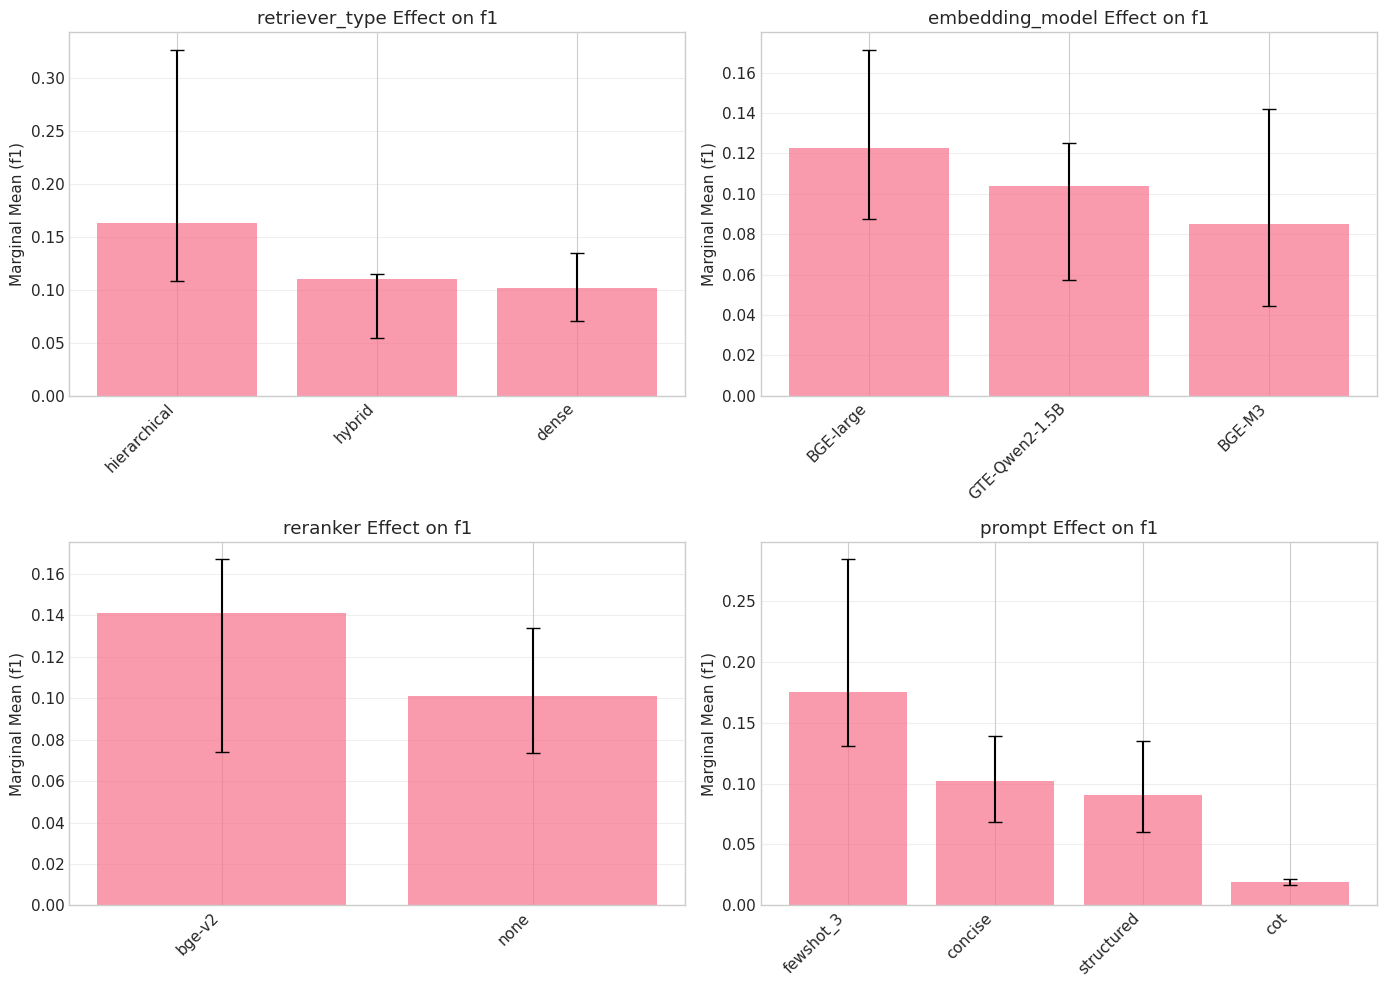

In [3]:
if len(rag_df) > 0:
    components = ['retriever_type', 'embedding_model', 'reranker', 'prompt', 'query_transform']
    available_components = [c for c in components if c in rag_df.columns and rag_df[c].nunique() > 1]
    
    print("Component Effects (Controlled for Model/Dataset)")
    print("=" * 60)
    
    for component in available_components:
        marginal = compute_marginal_means(rag_df, component)
        
        if not marginal.empty:
            print(f"\n{component}:")
            for _, row in marginal.iterrows():
                print(f"  {row[component]:20s}: {row['marginal_mean']:.4f} (n={row['n_experiments']})")
    
    # Visualization for top components
    n_plots = min(len(available_components), 4)
    if n_plots > 0:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        for i, component in enumerate(available_components[:n_plots]):
            plot_component_effects(df, component, ax=axes[i])
        
        for i in range(n_plots, 4):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()

## 3.3 Dataset-Specific Best Configurations

In [4]:
if len(rag_df) > 0 and 'dataset' in rag_df.columns:
    print("Best Configuration per Dataset")
    print("=" * 60)
    
    for dataset in sorted(rag_df['dataset'].unique()):
        ds_df = rag_df[rag_df['dataset'] == dataset]
        if len(ds_df) == 0:
            continue
        
        best_idx = ds_df[PRIMARY_METRIC].idxmax()
        best = ds_df.loc[best_idx]
        
        print(f"\n{dataset.upper()}: {PRIMARY_METRIC}={best[PRIMARY_METRIC]:.4f}")
        print(f"  Model: {best.get('model_short', 'N/A')}")
        print(f"  Retriever: {best.get('retriever_type', 'N/A')} / {best.get('embedding_model', 'N/A')}")
        print(f"  Query: {best.get('query_transform', 'none')}")
        print(f"  Reranker: {best.get('reranker', 'none')}")
        print(f"  Prompt: {best.get('prompt', 'N/A')}")

Best Configuration per Dataset

HOTPOTQA: f1=0.1805
  Model: Llama-3.2-3B
  Retriever: hybrid / BGE-large
  Query: none
  Reranker: none
  Prompt: fewshot_3

NQ: f1=0.2612
  Model: Llama-3.2-3B
  Retriever: dense / BGE-M3
  Query: hyde
  Reranker: bge-v2
  Prompt: fewshot_3

TRIVIAQA: f1=0.5492
  Model: Llama-3.2-3B
  Retriever: hierarchical / BGE-large
  Query: multiquery
  Reranker: bge-v2
  Prompt: fewshot_3


## 3.4 Component Interactions

Which component combinations work well together?

Component Interaction Analysis


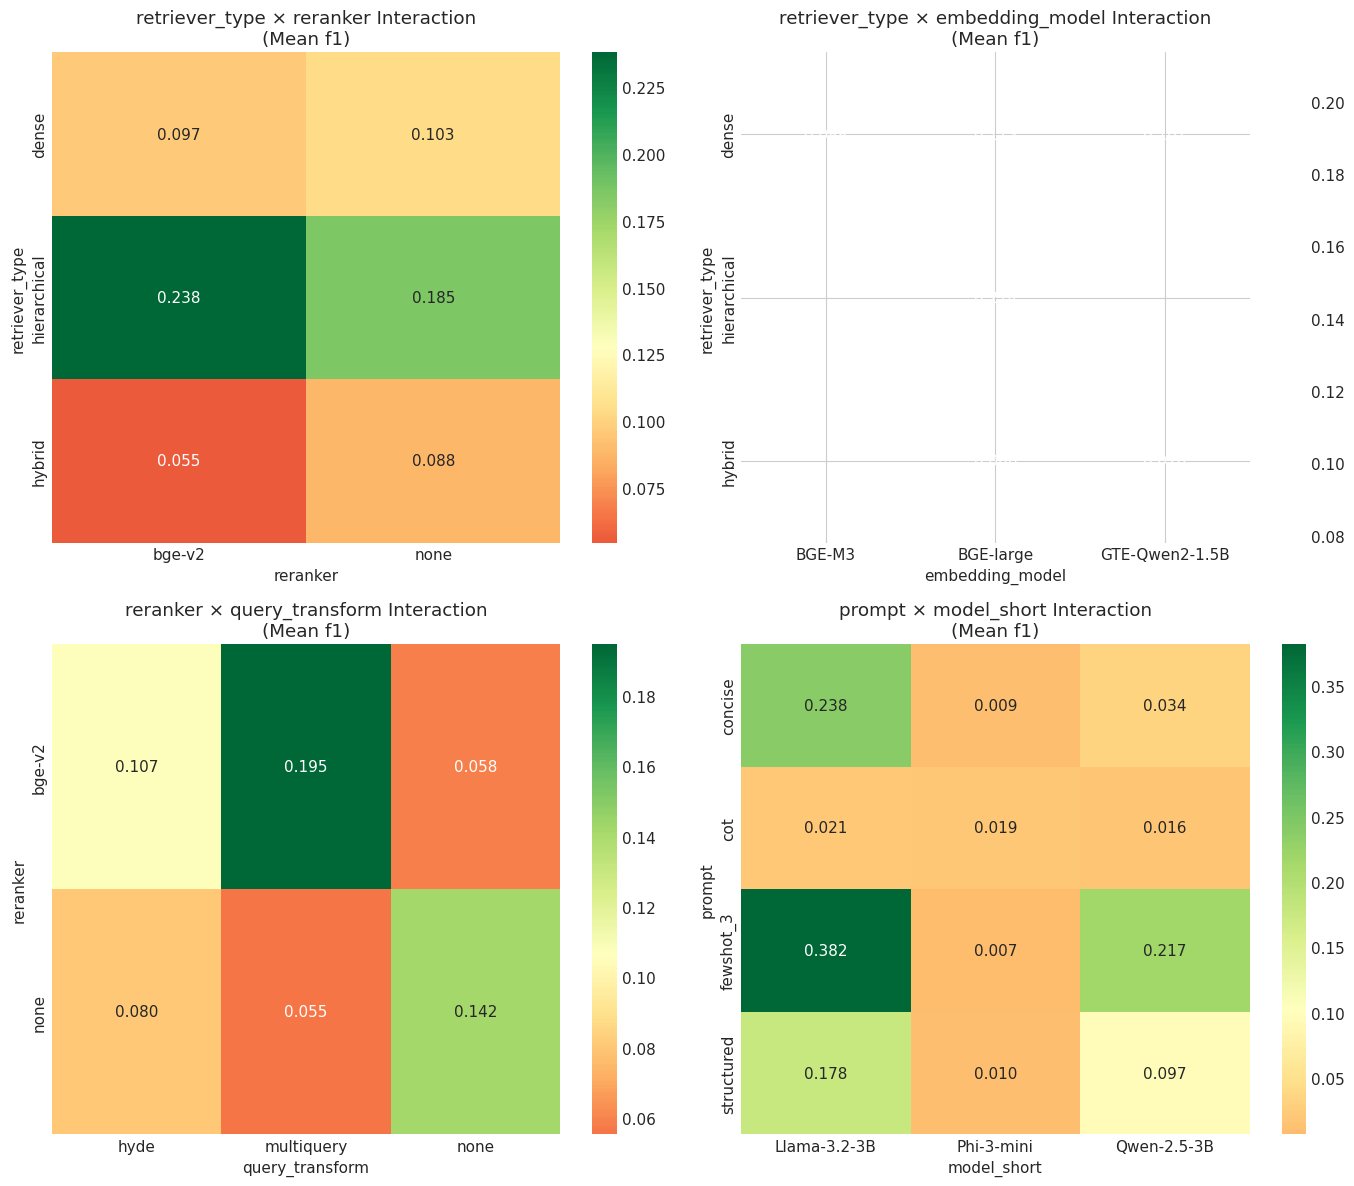

In [5]:
if len(rag_df) > 10:
    interactions = [
        ('retriever_type', 'reranker'),
        ('retriever_type', 'embedding_model'),
        ('reranker', 'query_transform'),
        ('prompt', 'model_short'),
    ]
    
    # Filter to valid interactions
    valid_interactions = []
    for f1, f2 in interactions:
        if f1 in rag_df.columns and f2 in rag_df.columns:
            n_combos = rag_df.groupby([f1, f2]).size()
            if len(n_combos) > 2:
                valid_interactions.append((f1, f2))
    
    if valid_interactions:
        print("Component Interaction Analysis")
        print("=" * 60)
        
        # Heatmaps
        n_plots = min(len(valid_interactions), 4)
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        axes = axes.flatten()
        
        for i, (f1, f2) in enumerate(valid_interactions[:n_plots]):
            plot_interaction_heatmap(df, f1, f2, ax=axes[i])
        
        for i in range(n_plots, 4):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()

## 3.5 Synergistic Combinations

In [6]:
if len(rag_df) > 10:
    print("Synergistic and Redundant Combinations")
    print("=" * 60)
    
    for f1, f2 in valid_interactions[:3]:
        synergies = find_synergistic_combinations(df, f1, f2)
        
        if synergies:
            print(f"\n{f1} × {f2}:")
            
            top_synergistic = [s for s in synergies if s['synergy'] == 'Synergistic'][:3]
            top_redundant = [s for s in synergies if s['synergy'] == 'Redundant'][:3]
            
            if top_synergistic:
                print("  Top Synergistic (better than expected):")
                for s in top_synergistic:
                    print(f"    - {s[f1]} + {s[f2]}: {s['actual']:.3f} (expected {s['expected']:.3f}, +{s['interaction_effect']:.3f})")
            
            if top_redundant:
                print("  Top Redundant (worse than expected):")
                for s in top_redundant:
                    print(f"    - {s[f1]} + {s[f2]}: {s['actual']:.3f} (expected {s['expected']:.3f}, {s['interaction_effect']:.3f})")

Synergistic and Redundant Combinations

retriever_type × reranker:
  Top Synergistic (better than expected):
    - hierarchical + bge-v2: 0.238 (expected 0.223, +0.015)
    - hybrid + none: 0.088 (expected 0.078, +0.010)
  Top Redundant (worse than expected):
    - dense + bge-v2: 0.097 (expected 0.111, -0.014)
    - hierarchical + none: 0.185 (expected 0.210, -0.025)
    - hybrid + bge-v2: 0.055 (expected 0.091, -0.037)

retriever_type × embedding_model:
  Top Synergistic (better than expected):
    - dense + GTE-Qwen2-1.5B: 0.101 (expected 0.083, +0.018)
    - hybrid + GTE-Qwen2-1.5B: 0.078 (expected 0.064, +0.014)
  Top Redundant (worse than expected):
    - hybrid + BGE-large: 0.086 (expected 0.103, -0.017)
    - hierarchical + BGE-large: 0.214 (expected 0.235, -0.022)

reranker × query_transform:
  Top Synergistic (better than expected):
    - bge-v2 + multiquery: 0.195 (expected 0.111, +0.083)
    - none + none: 0.142 (expected 0.120, +0.022)
  Top Redundant (worse than expected)

## 3.6 Key Takeaways

In [7]:
if len(rag_df) > 0:
    print("KEY TAKEAWAYS")
    print("=" * 60)
    
    bottlenecks = identify_bottlenecks(df)
    
    if bottlenecks:
        # Top bottleneck
        top = list(bottlenecks.keys())[0]
        print(f"\n1. TOP PRIORITY: Optimize {top} ({bottlenecks[top]:.1f}% of variance)")
        
        # Best values for each component
        print("\n2. RECOMMENDED VALUES:")
        for component in ['retriever_type', 'embedding_model', 'reranker', 'prompt']:
            if component in rag_df.columns and rag_df[component].nunique() > 1:
                marginal = compute_marginal_means(rag_df, component)
                if not marginal.empty:
                    best = marginal.iloc[0][component]
                    print(f"   - {component}: {best}")
        
        # Low-impact components
        low_impact = [k for k, v in bottlenecks.items() if v < 5]
        if low_impact:
            print(f"\n3. LOW IMPACT (can use defaults): {', '.join(low_impact)}")

KEY TAKEAWAYS

1. TOP PRIORITY: Optimize model_short (35.5% of variance)

2. RECOMMENDED VALUES:
   - retriever_type: hierarchical
   - embedding_model: BGE-large
   - reranker: bge-v2
   - prompt: fewshot_3

3. LOW IMPACT (can use defaults): top_k, embedding_model, query_transform, reranker
